#  Customer Segmentation

# 1. Data Preparation

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
import matplotlib.lines as mlines
import random 
import datetime as dt
import re
import pickle
import nltk, warnings
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import digits, punctuation

from scipy.stats import chi2_contingency

from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import os
import chart_studio

## 1.1 Import data and undertand data

In [2]:
data = pd.read_csv("Online Retail.csv",parse_dates= ['InvoiceDate'])
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
data.shape

(541909, 8)

In [5]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
data.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [7]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
cat_df = data.select_dtypes(include=['object'])
num_df = data.select_dtypes(exclude=['object'])

def printColumnTypes(non_numeric_df, numeric_df):
    '''separates non-numeric and numeric columns'''
    print("Non-Numeric columns:")
    for col in non_numeric_df:
     print(f"{col}")
    print("")
    print("Numeric columns:")
    for col in numeric_df:
     print(f"{col}")
        
printColumnTypes(cat_df, num_df)

Non-Numeric columns:
InvoiceNo
StockCode
Description
Country

Numeric columns:
Quantity
InvoiceDate
UnitPrice
CustomerID


## 1.2 Find missinf values

In [9]:
def missing_cols(df):
    '''prints out columns with its amount of missing values'''
    total = 0
    for col in df.columns:
        missing_vals = df[col].isnull().sum()
        total += missing_vals
        if missing_vals != 0:
            print(f"{col} => {df[col].isnull().sum()}")
    
    if total == 0:
        print("no missing values left")
missing_cols(data)

Description => 1454
CustomerID => 135080


In [10]:
def perc_missing(df):
    '''prints out columns with missing values with its %'''
    for col in df.columns:
        pct = df[col].isna().mean() * 100
        if (pct != 0):
            print('{} => {}%'.format(col, round(pct, 2)))
    
perc_missing(data)

Description => 0.27%
CustomerID => 24.93%


Text(0.5, 1.0, 'Ratio of missing values per columns')

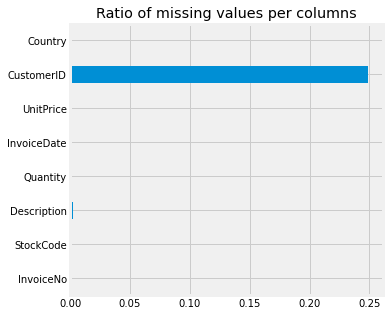

In [11]:
plt.figure(figsize=(5, 5))
data.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

<AxesSubplot:>

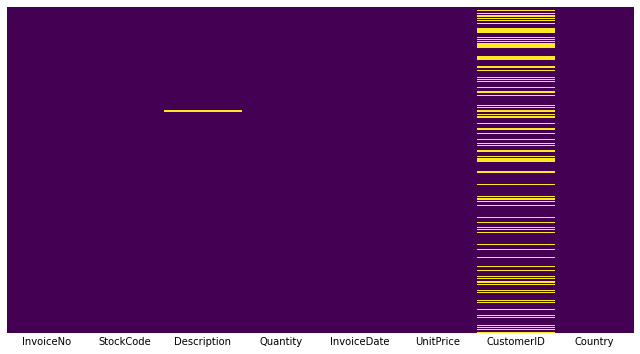

In [12]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), yticklabels=False, cmap='viridis', cbar=False)

In [13]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%Y-%m-%d')
data['InvoiceDate'].dtype.type

numpy.datetime64

In [14]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [16]:
data.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [17]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [18]:
df = data[['CustomerID','InvoiceNo','StockCode','Quantity','UnitPrice','Description','InvoiceDate','Country']]

In [19]:
df.head()

,CustomerID,InvoiceNo,StockCode,Quantity,UnitPrice,Description,InvoiceDate,Country
0,17850.0,536365,85123A,6,2.55,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-01 08:26:00,United Kingdom
1,17850.0,536365,71053,6,3.39,WHITE METAL LANTERN,2010-12-01 08:26:00,United Kingdom
2,17850.0,536365,84406B,8,2.75,CREAM CUPID HEARTS COAT HANGER,2010-12-01 08:26:00,United Kingdom
3,17850.0,536365,84029G,6,3.39,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00,United Kingdom
4,17850.0,536365,84029E,6,3.39,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00,United Kingdom


### Sale Performance

In [20]:
TotalAmount = df['Quantity'] * df['UnitPrice']
df.insert(loc=5,column='TotalAmount',value=TotalAmount)

In [21]:
df

,CustomerID,InvoiceNo,StockCode,Quantity,UnitPrice,TotalAmount,Description,InvoiceDate,Country
0,17850.0,536365,85123A,6,2.55,15.30,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-01 08:26:00,United Kingdom
1,17850.0,536365,71053,6,3.39,20.34,WHITE METAL LANTERN,2010-12-01 08:26:00,United Kingdom
2,17850.0,536365,84406B,8,2.75,22.00,CREAM CUPID HEARTS COAT HANGER,2010-12-01 08:26:00,United Kingdom
3,17850.0,536365,84029G,6,3.39,20.34,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00,United Kingdom
4,17850.0,536365,84029E,6,3.39,20.34,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00,United Kingdom
...,...,...,...,...,...,...,...,...,...
541904,12680.0,581587,22613,12,0.85,10.20,PACK OF 20 SPACEBOY NAPKINS,2011-12-09 12:50:00,France
541905,12680.0,581587,22899,6,2.10,12.60,CHILDREN'S APRON DOLLY GIRL,2011-12-09 12:50:00,France
541906,12680.0,581587,23254,4,4.15,16.60,CHILDRENS CUTLERY DOLLY GIRL,2011-12-09 12:50:00,France
541907,12680.0,581587,23255,4,4.15,16.60,CHILDRENS CUTLERY CIRCUS PARADE,2011-12-09 12:50:00,France


In [22]:
new_df = df[['CustomerID','InvoiceNo','StockCode','Quantity','UnitPrice','TotalAmount','Description','InvoiceDate','Country']]

In [23]:
new_df.head()

,CustomerID,InvoiceNo,StockCode,Quantity,UnitPrice,TotalAmount,Description,InvoiceDate,Country
0,17850.0,536365,85123A,6,2.55,15.30,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-01 08:26:00,United Kingdom
1,17850.0,536365,71053,6,3.39,20.34,WHITE METAL LANTERN,2010-12-01 08:26:00,United Kingdom
2,17850.0,536365,84406B,8,2.75,22.00,CREAM CUPID HEARTS COAT HANGER,2010-12-01 08:26:00,United Kingdom
3,17850.0,536365,84029G,6,3.39,20.34,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00,United Kingdom
4,17850.0,536365,84029E,6,3.39,20.34,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00,United Kingdom


In [24]:
country_Quantity = new_df.groupby('Country')['Quantity'].sum().sort_values(ascending = False)
country_Quantity

Country
United Kingdom          4263829
Netherlands              200128
EIRE                     142637
Germany                  117448
France                   110480
Australia                 83653
Sweden                    35637
Switzerland               30325
Spain                     26824
Japan                     25218
Belgium                   23152
Norway                    19247
Portugal                  16180
Finland                   10666
Channel Islands            9479
Denmark                    8188
Italy                      7999
Cyprus                     6317
Singapore                  5234
Austria                    4827
Hong Kong                  4769
Israel                     4353
Poland                     3653
Unspecified                3300
Canada                     2763
Iceland                    2458
Greece                     1556
USA                        1034
United Arab Emirates        982
Malta                       944
Lithuania                   652


<AxesSubplot:xlabel='Country'>

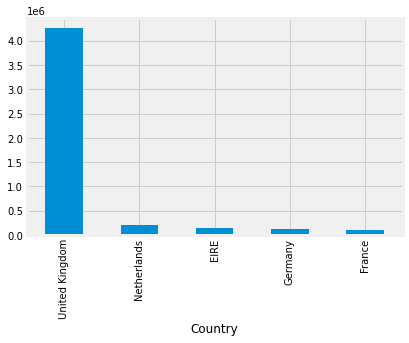

In [25]:
country_Quantity[:5].plot(kind = 'bar')

In [26]:
nan_rows = new_df[new_df.isnull().T.any().T]
nan_rows.head(5)

,CustomerID,InvoiceNo,StockCode,Quantity,UnitPrice,TotalAmount,Description,InvoiceDate,Country
622,NaN,536414,22139,56,0.00,0.00,NaN,2010-12-01 11:52:00,United Kingdom
1443,NaN,536544,21773,1,2.51,2.51,DECORATIVE ROSE BATHROOM BOTTLE,2010-12-01 14:32:00,United Kingdom
1444,NaN,536544,21774,2,2.51,5.02,DECORATIVE CATS BATHROOM BOTTLE,2010-12-01 14:32:00,United Kingdom
1445,NaN,536544,21786,4,0.85,3.40,POLKADOT RAIN HAT,2010-12-01 14:32:00,United Kingdom
1446,NaN,536544,21787,2,1.66,3.32,RAIN PONCHO RETROSPOT,2010-12-01 14:32:00,United Kingdom


# 2. Data Cleaning 

In [118]:
new_df = new_df.dropna(subset=["CustomerID"])

In [120]:
new_df

,CustomerID,InvoiceNo,StockCode,Quantity,UnitPrice,TotalAmount,Description,InvoiceDate,Country
0,17850,536365,85123A,6,2.55,15.30,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-01 08:26:00,United Kingdom
1,17850,536365,71053,6,3.39,20.34,WHITE METAL LANTERN,2010-12-01 08:26:00,United Kingdom
2,17850,536365,84406B,8,2.75,22.00,CREAM CUPID HEARTS COAT HANGER,2010-12-01 08:26:00,United Kingdom
3,17850,536365,84029G,6,3.39,20.34,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00,United Kingdom
4,17850,536365,84029E,6,3.39,20.34,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00,United Kingdom
...,...,...,...,...,...,...,...,...,...
541904,12680,581587,22613,12,0.85,10.20,PACK OF 20 SPACEBOY NAPKINS,2011-12-09 12:50:00,France
541905,12680,581587,22899,6,2.10,12.60,CHILDREN'S APRON DOLLY GIRL,2011-12-09 12:50:00,France
541906,12680,581587,23254,4,4.15,16.60,CHILDRENS CUTLERY DOLLY GIRL,2011-12-09 12:50:00,France
541907,12680,581587,23255,4,4.15,16.60,CHILDRENS CUTLERY CIRCUS PARADE,2011-12-09 12:50:00,France


In [28]:
new_df.head()

,CustomerID,InvoiceNo,StockCode,Quantity,UnitPrice,TotalAmount,Description,InvoiceDate,Country
0,17850.0,536365,85123A,6,2.55,15.30,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-01 08:26:00,United Kingdom
1,17850.0,536365,71053,6,3.39,20.34,WHITE METAL LANTERN,2010-12-01 08:26:00,United Kingdom
2,17850.0,536365,84406B,8,2.75,22.00,CREAM CUPID HEARTS COAT HANGER,2010-12-01 08:26:00,United Kingdom
3,17850.0,536365,84029G,6,3.39,20.34,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00,United Kingdom
4,17850.0,536365,84029E,6,3.39,20.34,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00,United Kingdom


In [29]:
new_df.isnull().sum()

CustomerID     0
InvoiceNo      0
StockCode      0
Quantity       0
UnitPrice      0
TotalAmount    0
Description    0
InvoiceDate    0
Country        0
dtype: int64

Text(0.5, 1.0, 'Ratio of missing values per columns')

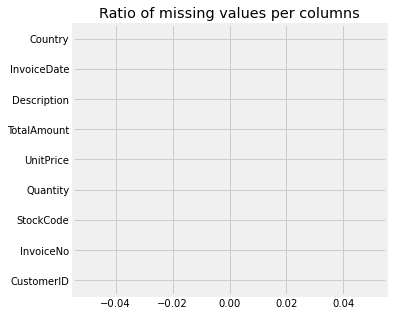

In [30]:
plt.figure(figsize=(5, 5))
new_df.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [31]:
print('Dupplicate entries: {}'.format(new_df.duplicated().sum()))
new_df.drop_duplicates(inplace = True)

Dupplicate entries: 5225


In [32]:
new_df.Country.nunique()

37

In [33]:
customer_country=new_df[['Country','CustomerID']].drop_duplicates()
customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


In [34]:
new_df.describe()

,CustomerID,Quantity,UnitPrice,TotalAmount
count,401604.000000,401604.000000,401604.000000,401604.000000
mean,15281.160818,12.183273,3.474064,20.613638
std,1714.006089,250.283037,69.764035,430.352218
min,12346.000000,-80995.000000,0.000000,-168469.600000
25%,13939.000000,2.000000,1.250000,4.250000
50%,15145.000000,5.000000,1.950000,11.700000
75%,16784.000000,12.000000,3.750000,19.800000
max,18287.000000,80995.000000,38970.000000,168469.600000


In [35]:
new_df[(new_df['Quantity']<0)].head(5)

,CustomerID,InvoiceNo,StockCode,Quantity,UnitPrice,TotalAmount,Description,InvoiceDate,Country
141,14527.0,C536379,D,-1,27.50,-27.50,Discount,2010-12-01 09:41:00,United Kingdom
154,15311.0,C536383,35004C,-1,4.65,-4.65,SET OF 3 COLOURED FLYING DUCKS,2010-12-01 09:49:00,United Kingdom
235,17548.0,C536391,22556,-12,1.65,-19.80,PLASTERS IN TIN CIRCUS PARADE,2010-12-01 10:24:00,United Kingdom
236,17548.0,C536391,21984,-24,0.29,-6.96,PACK OF 12 PINK PAISLEY TISSUES,2010-12-01 10:24:00,United Kingdom
237,17548.0,C536391,21983,-24,0.29,-6.96,PACK OF 12 BLUE PAISLEY TISSUES,2010-12-01 10:24:00,United Kingdom


In [36]:
# Constructing a basket for later use
temp = new_df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
product_number = temp.rename(columns = {'InvoiceDate':'Number of products'})

In [37]:
product_number.InvoiceNo = product_number.InvoiceNo.astype(str)
product_number['order_canceled'] = product_number['InvoiceNo'].apply(lambda x:int('C' in x))
len(product_number[product_number['order_canceled']==1])/len(product_number)*100

16.466876971608833

In [38]:
product_number[product_number['order_canceled']==1][:10]

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346.0,C541433,1,1
23,12352.0,C545329,2,1
24,12352.0,C545330,1,1
25,12352.0,C547388,7,1
39,12359.0,C549955,2,1
40,12359.0,C580165,4,1
55,12362.0,C544902,2,1
56,12362.0,C563752,3,1
57,12362.0,C579178,3,1
66,12365.0,C544577,1,1


## 2.1. Convert CustomerID from float to Int

In [39]:
new_df['CustomerID'] = new_df['CustomerID'].astype('int64')
new_df['CustomerID'].dtype

dtype('int64')

## 2.2. Verify CustomersID 

In [40]:
new_df[new_df['CustomerID'] == 12346]

,CustomerID,InvoiceNo,StockCode,Quantity,UnitPrice,TotalAmount,Description,InvoiceDate,Country
61619,12346,541431,23166,74215,1.04,77183.6,MEDIUM CERAMIC TOP STORAGE JAR,2011-01-18 10:01:00,United Kingdom
61624,12346,C541433,23166,-74215,1.04,-77183.6,MEDIUM CERAMIC TOP STORAGE JAR,2011-01-18 10:17:00,United Kingdom


## 2.3. Test Canceled Invoices

In [41]:
new_df[new_df['InvoiceNo'] == 'C547388']

,CustomerID,InvoiceNo,StockCode,Quantity,UnitPrice,TotalAmount,Description,InvoiceDate,Country
129737,12352,C547388,84050,-12,1.65,-19.80,PINK HEART SHAPE EGG FRYING PAN,2011-03-22 16:07:00,Norway
129738,12352,C547388,37448,-12,1.49,-17.88,CERAMIC CAKE DESIGN SPOTTED MUG,2011-03-22 16:07:00,Norway
129739,12352,C547388,22784,-3,4.95,-14.85,LANTERN CREAM GAZEBO,2011-03-22 16:07:00,Norway
129740,12352,C547388,22701,-6,2.95,-17.70,PINK DOG BOWL,2011-03-22 16:07:00,Norway
129741,12352,C547388,22645,-12,1.45,-17.40,CERAMIC HEART FAIRY CAKE MONEY BANK,2011-03-22 16:07:00,Norway
129742,12352,C547388,22413,-6,2.95,-17.70,METAL SIGN TAKE IT OR LEAVE IT,2011-03-22 16:07:00,Norway
129743,12352,C547388,21914,-12,1.25,-15.00,BLUE HARMONICA IN BOX,2011-03-22 16:07:00,Norway


In [42]:
new_df[new_df['InvoiceNo']=='C579178']

,CustomerID,InvoiceNo,StockCode,Quantity,UnitPrice,TotalAmount,Description,InvoiceDate,Country
507365,12362,C579178,22941,-2,8.50,-17.00,CHRISTMAS LIGHTS 10 REINDEER,2011-11-28 14:55:00,Belgium
507366,12362,C579178,22942,-2,8.50,-17.00,CHRISTMAS LIGHTS 10 SANTAS,2011-11-28 14:55:00,Belgium
507367,12362,C579178,22943,-3,4.95,-14.85,CHRISTMAS LIGHTS 10 VINTAGE BAUBLES,2011-11-28 14:55:00,Belgium


## 2.4. Test CustomerID

In [43]:
test = new_df[new_df['Quantity'] < 0][['CustomerID','Quantity','StockCode','Description','UnitPrice']]
for index, col in  test.iterrows():
    if new_df[(new_df['CustomerID'] == col[0]) & (new_df['Quantity'] == -col[1]) 
                & (new_df['Description'] == col[2])].shape[0] == 0: 
     print(test.loc[index])
     print('Our initial hypothesis is wrong')
     break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
Our initial hypothesis is wrong


In [44]:
new_df[new_df['CustomerID'] == 14527].head(5)

,CustomerID,InvoiceNo,StockCode,Quantity,UnitPrice,TotalAmount,Description,InvoiceDate,Country
141,14527,C536379,D,-1,27.50,-27.50,Discount,2010-12-01 09:41:00,United Kingdom
8963,14527,537159,22112,6,4.95,29.70,CHOCOLATE HOT WATER BOTTLE,2010-12-05 13:17:00,United Kingdom
8964,14527,537159,22111,1,4.95,4.95,SCOTTIE DOG HOT WATER BOTTLE,2010-12-05 13:17:00,United Kingdom
8965,14527,537159,21479,1,3.75,3.75,WHITE SKULL HOT WATER BOTTLE,2010-12-05 13:17:00,United Kingdom
8966,14527,537159,22114,6,3.95,23.70,HOT WATER BOTTLE TEA AND SYMPATHY,2010-12-05 13:17:00,United Kingdom


In [45]:
data_check = new_df[(new_df['Quantity'] < 0) & (new_df['Description'] != 'Discount')][['CustomerID','Quantity','StockCode','Description','UnitPrice']]

for index, col in  data_check.iterrows():
    if new_df[(new_df['CustomerID'] == col[0]) & (new_df['Quantity'] == -col[1]) 
                & (new_df['Description'] == col[2])].shape[0] == 0: 
        print(index, data_check.loc[index])
        print('The second hypothesis is also wrong')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
The second hypothesis is also wrong


In [46]:
new_df[(new_df['CustomerID'] == 15311) & (new_df['Description'] == 'SET OF 3 COLOURED  FLYING DUCKS')]

,CustomerID,InvoiceNo,StockCode,Quantity,UnitPrice,TotalAmount,Description,InvoiceDate,Country
154,15311,C536383,35004C,-1,4.65,-4.65,SET OF 3 COLOURED FLYING DUCKS,2010-12-01 09:49:00,United Kingdom
9200,15311,537195,35004C,12,4.65,55.80,SET OF 3 COLOURED FLYING DUCKS,2010-12-05 13:55:00,United Kingdom
18196,15311,C537805,35004C,-1,4.65,-4.65,SET OF 3 COLOURED FLYING DUCKS,2010-12-08 13:18:00,United Kingdom
28630,15311,538651,35004C,12,4.65,55.80,SET OF 3 COLOURED FLYING DUCKS,2010-12-13 15:07:00,United Kingdom
39381,15311,C539640,35004C,-3,4.65,-13.95,SET OF 3 COLOURED FLYING DUCKS,2010-12-20 15:27:00,United Kingdom
44157,15311,540157,35004C,12,4.65,55.80,SET OF 3 COLOURED FLYING DUCKS,2011-01-05 11:41:00,United Kingdom
59542,15311,541293,35004C,12,4.65,55.80,SET OF 3 COLOURED FLYING DUCKS,2011-01-17 13:39:00,United Kingdom
78333,15311,C542866,35004C,-2,4.65,-9.30,SET OF 3 COLOURED FLYING DUCKS,2011-02-01 12:14:00,United Kingdom


## 2.5. Remove NaN and douplicat

In [47]:
df_cleaned = new_df.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  new_df.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = new_df[(new_df['CustomerID'] == col['CustomerID']) &
                         (new_df['StockCode'] == col['StockCode']) & 
                         (new_df['InvoiceDate'] < col['InvoiceDate']) & 
                         (new_df['Quantity'] > 0)].copy()
    
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis= 0 ,ascending= False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break   

In [48]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 7521
doubtfull_entry: 1226


In [49]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401604 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   CustomerID        401604 non-null  int64         
 1   InvoiceNo         401604 non-null  object        
 2   StockCode         401604 non-null  object        
 3   Quantity          401604 non-null  int64         
 4   UnitPrice         401604 non-null  float64       
 5   TotalAmount       401604 non-null  float64       
 6   Description       401604 non-null  object        
 7   InvoiceDate       401604 non-null  datetime64[ns]
 8   Country           401604 non-null  object        
 9   QuantityCanceled  401604 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 41.8+ MB


In [50]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 48


,CustomerID,InvoiceNo,StockCode,Quantity,UnitPrice,TotalAmount,Description,InvoiceDate,Country,QuantityCanceled
77598,15358,C542742,84535B,-94,0.65,-61.10,FAIRY CAKES NOTEBOOK A6 SIZE,2011-01-31 16:26:00,United Kingdom,0
90444,14659,C544038,22784,-4,4.95,-19.80,LANTERN CREAM GAZEBO,2011-02-15 11:32:00,United Kingdom,0
111968,14048,C545852,22464,-5,1.65,-8.25,HANGING METAL HEART LANTERN,2011-03-07 13:49:00,United Kingdom,0
116064,16422,C546191,47566B,-35,0.70,-24.50,TEA TIME PARTY BUNTING,2011-03-10 10:57:00,United Kingdom,0
132642,17754,C547675,22263,-49,0.66,-32.34,FELT EGG COSY LADYBIRD,2011-03-24 14:07:00,United Kingdom,0


In [51]:
df_cleaned.drop(remaining_entries.index, axis = 0, inplace = True)

In [52]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392809 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   CustomerID        392809 non-null  int64         
 1   InvoiceNo         392809 non-null  object        
 2   StockCode         392809 non-null  object        
 3   Quantity          392809 non-null  int64         
 4   UnitPrice         392809 non-null  float64       
 5   TotalAmount       392809 non-null  float64       
 6   Description       392809 non-null  object        
 7   InvoiceDate       392809 non-null  datetime64[ns]
 8   Country           392809 non-null  object        
 9   QuantityCanceled  392809 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 33.0+ MB


In [53]:
df_cleaned.head(10)

,CustomerID,InvoiceNo,StockCode,Quantity,UnitPrice,TotalAmount,Description,InvoiceDate,Country,QuantityCanceled
0,17850,536365,85123A,6,2.55,15.30,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-01 08:26:00,United Kingdom,0
1,17850,536365,71053,6,3.39,20.34,WHITE METAL LANTERN,2010-12-01 08:26:00,United Kingdom,0
2,17850,536365,84406B,8,2.75,22.00,CREAM CUPID HEARTS COAT HANGER,2010-12-01 08:26:00,United Kingdom,0
3,17850,536365,84029G,6,3.39,20.34,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00,United Kingdom,0
4,17850,536365,84029E,6,3.39,20.34,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00,United Kingdom,0
5,17850,536365,22752,2,7.65,15.30,SET 7 BABUSHKA NESTING BOXES,2010-12-01 08:26:00,United Kingdom,0
6,17850,536365,21730,6,4.25,25.50,GLASS STAR FROSTED T-LIGHT HOLDER,2010-12-01 08:26:00,United Kingdom,0
7,17850,536366,22633,6,1.85,11.10,HAND WARMER UNION JACK,2010-12-01 08:28:00,United Kingdom,0
8,17850,536366,22632,6,1.85,11.10,HAND WARMER RED POLKA DOT,2010-12-01 08:28:00,United Kingdom,0
9,13047,536367,84879,32,1.69,54.08,ASSORTED COLOUR BIRD ORNAMENT,2010-12-01 08:34:00,United Kingdom,0


## 2.6. StockCode contain string

In [54]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [55]:
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'POST']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'D']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'C2']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'M']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'BANK CHARGES']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'PADS']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'DOT']

In [56]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391183 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   CustomerID        391183 non-null  int64         
 1   InvoiceNo         391183 non-null  object        
 2   StockCode         391183 non-null  object        
 3   Quantity          391183 non-null  int64         
 4   UnitPrice         391183 non-null  float64       
 5   TotalAmount       391183 non-null  float64       
 6   Description       391183 non-null  object        
 7   InvoiceDate       391183 non-null  datetime64[ns]
 8   Country           391183 non-null  object        
 9   QuantityCanceled  391183 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 32.8+ MB


## 2.7. Check the Outlier

In [57]:
df_cleaned.describe()

,CustomerID,Quantity,UnitPrice,TotalAmount,QuantityCanceled
count,391183.000000,391183.000000,391183.000000,391183.000000,391183.000000
mean,15295.083503,13.179665,2.874130,22.335397,0.626569
std,1710.359579,181.907403,4.284639,310.919394,175.902239
min,12346.000000,1.000000,0.000000,0.000000,0.000000
25%,13969.000000,2.000000,1.250000,4.950000,0.000000
50%,15158.000000,6.000000,1.950000,11.900000,0.000000
75%,16794.000000,12.000000,3.750000,19.800000,0.000000
max,18287.000000,80995.000000,649.500000,168469.600000,80995.000000


In [58]:
df_cleaned[(df_cleaned['UnitPrice'] == 0)].head(5)

,CustomerID,InvoiceNo,StockCode,Quantity,UnitPrice,TotalAmount,Description,InvoiceDate,Country,QuantityCanceled
9302,12647,537197,22841,1,0.0,0.0,ROUND CAKE TIN VINTAGE GREEN,2010-12-05 14:02:00,Germany,0
33576,16560,539263,22580,4,0.0,0.0,ADVENT CALENDAR GINGHAM SACK,2010-12-16 14:36:00,United Kingdom,0
40089,14911,539722,22423,10,0.0,0.0,REGENCY CAKESTAND 3 TIER,2010-12-21 13:45:00,EIRE,0
47068,13081,540372,22090,24,0.0,0.0,PAPER BUNTING RETROSPOT,2011-01-06 16:41:00,United Kingdom,0
47070,13081,540372,22553,24,0.0,0.0,PLASTERS IN TIN SKULLS,2011-01-06 16:41:00,United Kingdom,0


In [59]:
df_cleaned[(df_cleaned['UnitPrice'] == 649.50)].head(5)

,CustomerID,InvoiceNo,StockCode,Quantity,UnitPrice,TotalAmount,Description,InvoiceDate,Country,QuantityCanceled
222680,15098,556444,22502,60,649.5,38970.0,PICNIC BASKET WICKER 60 PIECES,2011-06-10 15:28:00,United Kingdom,60
222682,15098,556446,22502,1,649.5,649.5,PICNIC BASKET WICKER 60 PIECES,2011-06-10 15:33:00,United Kingdom,0


## 2.8. Count

In [60]:
def unique_counts(data):
   for i in data.columns:
       count = data[i].nunique()
       print(i, ": ", count)
unique_counts(df_cleaned)

CustomerID :  4335
InvoiceNo :  18405
StockCode :  3659
Quantity :  300
UnitPrice :  356
TotalAmount :  2856
Description :  3871
InvoiceDate :  17169
Country :  37
QuantityCanceled :  122


## 2.9. Find Revenue per country

In [61]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])

Text(0.5, 1.0, 'Revenue per Country')

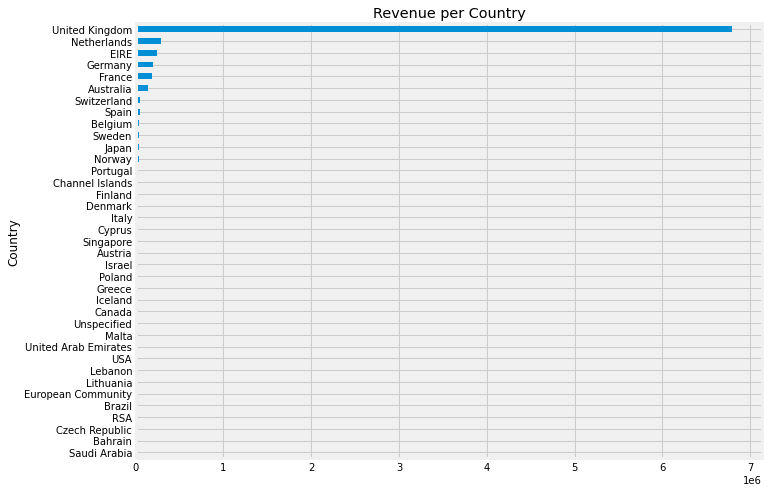

In [62]:
revenue_per_countries = df_cleaned.groupby(["Country"])["TotalPrice"].sum().sort_values()
revenue_per_countries.plot(kind='barh', figsize=(10,8))
plt.title("Revenue per Country")

## 2.10. Change Country name to code

In [63]:
countrycode = LabelEncoder()
countrycode.fit(df_cleaned['Country'])

LabelEncoder()

In [64]:
l = [i for i in range(37)]
dict(zip(list(countrycode.classes_), l))

{'Australia': 0,
 'Austria': 1,
 'Bahrain': 2,
 'Belgium': 3,
 'Brazil': 4,
 'Canada': 5,
 'Channel Islands': 6,
 'Cyprus': 7,
 'Czech Republic': 8,
 'Denmark': 9,
 'EIRE': 10,
 'European Community': 11,
 'Finland': 12,
 'France': 13,
 'Germany': 14,
 'Greece': 15,
 'Iceland': 16,
 'Israel': 17,
 'Italy': 18,
 'Japan': 19,
 'Lebanon': 20,
 'Lithuania': 21,
 'Malta': 22,
 'Netherlands': 23,
 'Norway': 24,
 'Poland': 25,
 'Portugal': 26,
 'RSA': 27,
 'Saudi Arabia': 28,
 'Singapore': 29,
 'Spain': 30,
 'Sweden': 31,
 'Switzerland': 32,
 'USA': 33,
 'United Arab Emirates': 34,
 'United Kingdom': 35,
 'Unspecified': 36}

In [65]:
df_cleaned['Country'] = countrycode.transform(df_cleaned['Country'])

In [66]:
with open('labelencoder.pickle', 'wb') as g:
 pickle.dump(countrycode, g)

In [67]:
df_cleaned.head(5)

,CustomerID,InvoiceNo,StockCode,Quantity,UnitPrice,TotalAmount,Description,InvoiceDate,Country,QuantityCanceled,TotalPrice
0,17850,536365,85123A,6,2.55,15.30,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-01 08:26:00,35,0,15.30
1,17850,536365,71053,6,3.39,20.34,WHITE METAL LANTERN,2010-12-01 08:26:00,35,0,20.34
2,17850,536365,84406B,8,2.75,22.00,CREAM CUPID HEARTS COAT HANGER,2010-12-01 08:26:00,35,0,22.00
3,17850,536365,84029G,6,3.39,20.34,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00,35,0,20.34
4,17850,536365,84029E,6,3.39,20.34,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00,35,0,20.34


# 3. RFM

### RFM stand for Recency Frequency and Monetary

### R = Last date - Last Invoice Date
### F = Count Invoice number of transection 
### M = Sum of Total amount for each customer

### 3.1. Find score of Recency, Frequency and Monetary for each customer

In [68]:
import datetime as dt

In [69]:
# The last invoce is 2011 -12 -09 so we set 2011-12-10 is the last date to culculate the number of days from puchasing day
Last_Date = dt.datetime(2011,12,10)
RFMscore = df_cleaned.groupby('CustomerID').agg({'InvoiceDate': lambda x: (Last_Date - x.max()).days,'InvoiceNo': lambda x: len(x),'TotalAmount': lambda x: x.sum()})
RFMscore['InvoiceDate'] = RFMscore['InvoiceDate'].astype(int)

# Rename clumn name to Recency, Frequency and Monetary
RFMscore.rename(columns = {'InvoiceDate':'Recency',
                         'InvoiceNo':'Frequency',
                         'TotalAmount':'Monetary'}, inplace= True)
RFMscore.reset_index().head()

,CustomerID,Recency,Frequency,Monetary
0,12346,325,1,77183.60
1,12347,2,182,4310.00
2,12348,75,27,1437.24
3,12349,18,72,1457.55
4,12350,310,16,294.40


In [70]:
RFMscore.Recency.describe()

count    4335.000000
mean       92.208535
std       100.170816
min         0.000000
25%        17.000000
50%        50.000000
75%       142.000000
max       373.000000
Name: Recency, dtype: float64

In [71]:
import seaborn as sns

C:\Users\asus\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


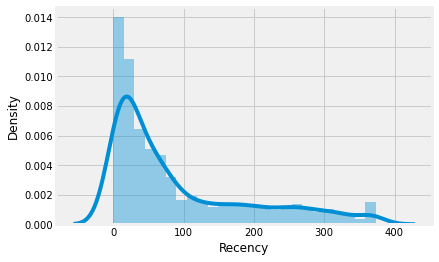

In [72]:
x = RFMscore['Recency']
ax = sns.distplot(x)

In [73]:
RFMscore.Frequency.describe()

count    4335.000000
mean       90.238293
std       224.712166
min         1.000000
25%        17.000000
50%        41.000000
75%        98.000000
max      7667.000000
Name: Frequency, dtype: float64

C:\Users\asus\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


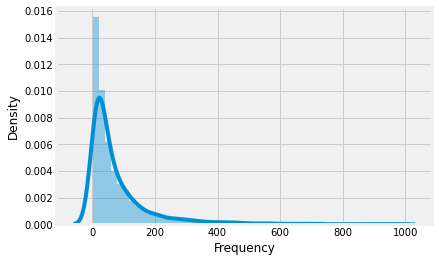

In [74]:
x = RFMscore.query('Frequency< 1000')['Frequency']
ax = sns.distplot(x)

In [75]:
RFMscore.Monetary.describe()

count      4335.000000
mean       2015.508106
std        8902.699230
min           0.000000
25%         304.105000
50%         661.520000
75%        1631.475000
max      279138.020000
Name: Monetary, dtype: float64

C:\Users\asus\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


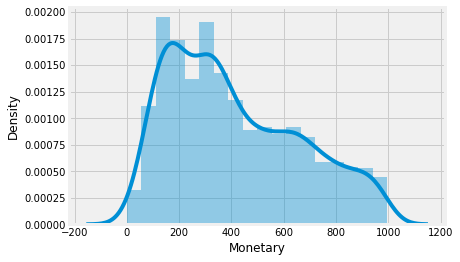

In [76]:
x = RFMscore.query('Monetary < 1000')['Monetary']
ax = sns.distplot(x)

### 3.2 Quantilesand creat score for R, F an M

In [77]:
quantiles = RFMscore.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [78]:
quantiles

{'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 142.0},
 'Frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 98.0},
 'Monetary': {0.25: 304.10499999999996, 0.5: 661.52, 0.75: 1631.4750000000001}}

In [79]:
def Rscore(x,p,d):
 if x <= d[p][0.25]:
  return 1
 elif x <= d[p][0.50]:
  return 2
 elif x <= d[p][0.75]: 
  return 3
 else:
  return 4
    
def FMscore(x,p,d):
 if x <= d[p][0.25]:
  return 4
 elif x <= d[p][0.50]:
  return 3
 elif x <= d[p][0.75]: 
  return 2
 else:
  return 1

In [80]:
RFMscore['R'] = RFMscore['Recency'].apply(Rscore, args = ('Recency',quantiles,))
RFMscore['F'] = RFMscore['Frequency'].apply(FMscore, args = ('Frequency',quantiles,))
RFMscore['M'] = RFMscore['Monetary'].apply(FMscore, args = ('Monetary',quantiles,))
RFMscore.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346,325,1,77183.60,4,4,1
12347,2,182,4310.00,1,1,1
12348,75,27,1437.24,3,3,2
12349,18,72,1457.55,2,2,2
12350,310,16,294.40,4,4,4


### 3.3. We we group RFM to create RFM score

In [81]:
RFMscore['RFMgroup'] = RFMscore.R.map(str) + RFMscore.F.map(str) + RFMscore.M.map(str)
RFMscore['RFMScore'] = RFMscore[['R','F','M']].sum(axis = 1)
RFMscore.head()

,Recency,Frequency,Monetary,R,F,M,RFMgroup,RFMScore
CustomerID,,,,,,,,
12346,325,1,77183.60,4,4,1,441,9
12347,2,182,4310.00,1,1,1,111,3
12348,75,27,1437.24,3,3,2,332,8
12349,18,72,1457.55,2,2,2,222,6
12350,310,16,294.40,4,4,4,444,12


### 3.4. Now we set the grade of customers

In [82]:
Grade_level = ['A','B','C','D']
Score_cuts = pd.qcut(RFMscore.RFMScore, q = 4, labels = Grade_level)
RFMscore['RFM_Grade'] = Score_cuts.values
RFMscore.reset_index().head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMgroup,RFMScore,RFM_Grade
0,12346,325,1,77183.60,4,4,1,441,9,C
1,12347,2,182,4310.00,1,1,1,111,3,A
2,12348,75,27,1437.24,3,3,2,332,8,B
3,12349,18,72,1457.55,2,2,2,222,6,B
4,12350,310,16,294.40,4,4,4,444,12,D


In [83]:
# Sorting Grade of customers
RFMscore[RFMscore['RFMgroup'] == '111'].sort_values('Monetary', ascending = False).reset_index().head(10)

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMgroup,RFMScore,RFM_Grade
0,14646,1,2064,279138.02,1,1,1,111,3,A
1,18102,0,431,259657.30,1,1,1,111,3,A
2,17450,8,336,194390.79,1,1,1,111,3,A
3,14911,1,5586,136161.83,1,1,1,111,3,A
4,14156,9,1382,116560.08,1,1,1,111,3,A
5,17511,2,963,91062.38,1,1,1,111,3,A
6,16684,4,277,66653.56,1,1,1,111,3,A
7,13694,3,568,65039.62,1,1,1,111,3,A
8,15311,0,2366,60632.75,1,1,1,111,3,A
9,13089,2,1814,58762.08,1,1,1,111,3,A


### The grade meaning
### A = The Best customers
### B = Loyal or Big spend
### C = Spend more but less frequency
### D = Almost Lost  or Lost
### ............

# 4. K-Mean Cluster Model

## 4.1 Transform data

In [84]:
def handle_neg_n_zero(num):
    if num<= 0:
        return 1
    else:
        return num
    # apply
RFMscore['Recency'] = [handle_neg_n_zero(x) for x in RFMscore.Recency]
RFMscore['Monetary'] = [handle_neg_n_zero(x) for x in RFMscore.Monetary]
# perform log tranform
Log_Tfd_Data = RFMscore[['Recency','Frequency','Monetary']].apply(np.log, axis=1).round(3)

C:\Users\asus\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


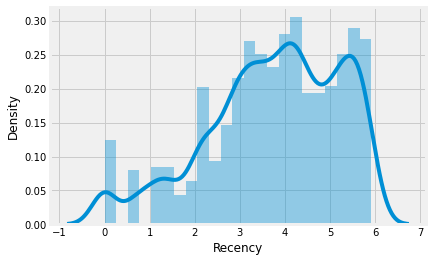

In [85]:
# Data Distribution for Recency
Recency_Plot = Log_Tfd_Data['Recency']
ax = sns.distplot(Recency_Plot)

C:\Users\asus\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


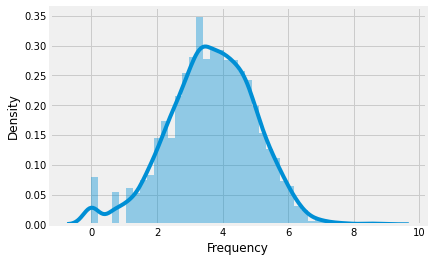

In [86]:
# distribution forFrequency
Frequency_Plot = Log_Tfd_Data.query('Frequency<10000')['Frequency']
ax = sns.distplot(Frequency_Plot)

C:\Users\asus\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


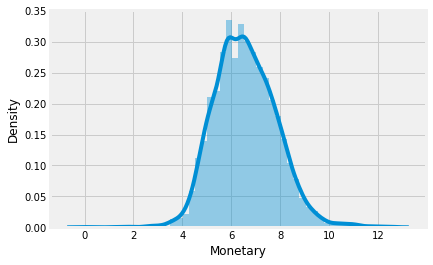

In [87]:
Monetary_Plot = Log_Tfd_Data.query('Monetary<10000')['Monetary']
ax = sns.distplot(Monetary_Plot)

## 4.2 We Scaling data

In [88]:
from sklearn.preprocessing import StandardScaler

In [89]:
scaleobj = StandardScaler()
Scaled_Data = scaleobj.fit_transform(Log_Tfd_Data)
Scaled_Data = pd.DataFrame(Scaled_Data, index = RFMscore.index, columns = Log_Tfd_Data.columns)

C:\Users\asus\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


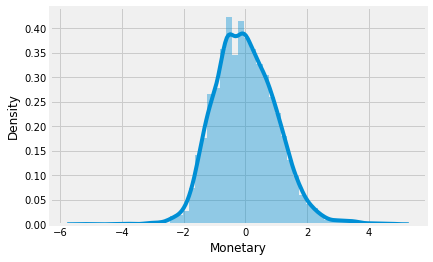

In [90]:
Monetary_Plot = Scaled_Data.query('Monetary<10000')['Monetary']
ax = sns.distplot(Monetary_Plot)

## 4.3 Use Elbow to optimize clusters

In [91]:
from sklearn.cluster import KMeans

In [92]:
sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters =k ,init= 'k-means++', max_iter =1000)
    km = km.fit(Scaled_Data)
    sum_of_sq_dist[k] = km.inertia_

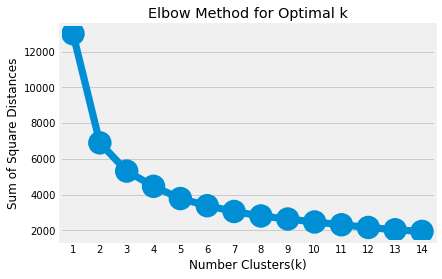

In [93]:
#plot the graph
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method for Optimal k')
plt.show()

### So we choose 3 Clusters

## 4.4. Clusters to segment customers

In [94]:
from kneed import KneeLocator

In [95]:
KMeans_cluster = KMeans(n_clusters = 3, init= 'k-means++', max_iter=1000)
KMeans_cluster.fit(Scaled_Data)

RFMscore['Clusters'] = KMeans_cluster.labels_
RFMscore.head()

,Recency,Frequency,Monetary,R,F,M,RFMgroup,RFMScore,RFM_Grade,Clusters
CustomerID,,,,,,,,,,
12346,325,1,77183.60,4,4,1,441,9,C,1
12347,2,182,4310.00,1,1,1,111,3,A,2
12348,75,27,1437.24,3,3,2,332,8,B,1
12349,18,72,1457.55,2,2,2,222,6,B,1
12350,310,16,294.40,4,4,4,444,12,D,0


<Figure size 504x504 with 0 Axes>

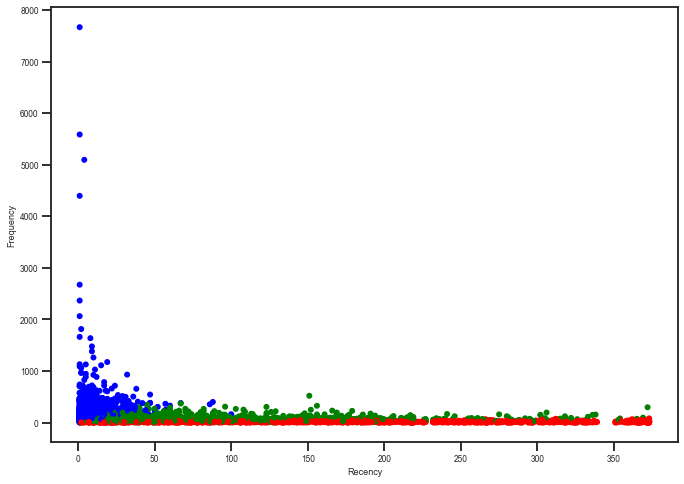

In [107]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7))

Colors = ['red','green','blue']
RFMscore['Color']= RFMscore['Clusters'].map(lambda p: Colors[p])
ax = RFMscore.plot(
    kind = 'scatter',
    x = 'Recency', y= 'Frequency',
    figsize = (10,8),
    c = RFMscore['Color']
)

In [108]:
RFMscore.head()

,Recency,Frequency,Monetary,R,F,M,RFMgroup,RFMScore,RFM_Grade,Clusters,Color
CustomerID,,,,,,,,,,,
12346,325,1,77183.60,4,4,1,441,9,C,1,green
12347,2,182,4310.00,1,1,1,111,3,A,2,blue
12348,75,27,1437.24,3,3,2,332,8,B,1,green
12349,18,72,1457.55,2,2,2,222,6,B,1,green
12350,310,16,294.40,4,4,4,444,12,D,0,red


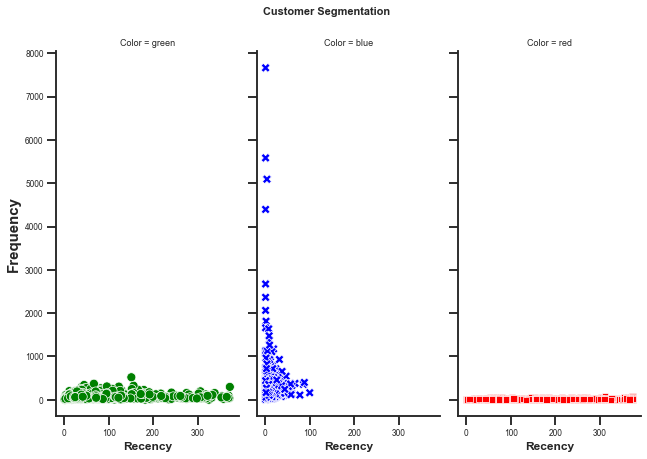

In [109]:
sns.set(rc={'figure.figsize':(20,20)}) 
sns.set_context('talk', font_scale=0.5) 
sns.set_style('ticks')
g = sns.relplot(x='Recency', y='Frequency',hue='Color', data=RFMscore,palette=['green','blue','red'],
                col='Color', col_wrap=3, legend=False,
                height =6, aspect=0.5, style='Color',sizes=(80,100))

g.fig.suptitle('Customer Segmentation' ,position=(0.5,1.05), fontweight='bold', size=11)
g.set_xlabels("Recency",fontweight='bold', size=12)
g.set_ylabels("Frequency",fontweight='bold', size=15);

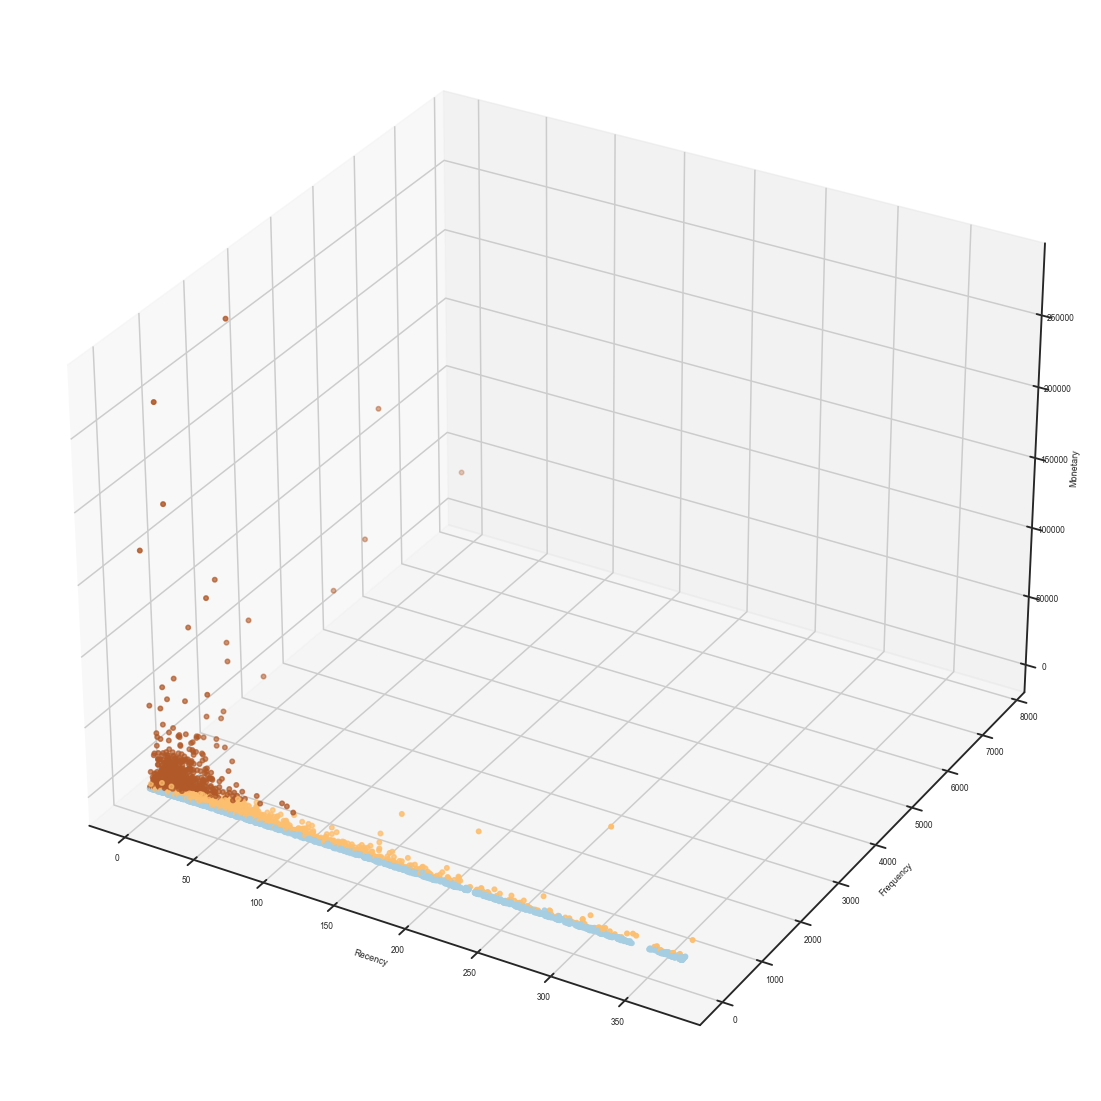

In [99]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = RFMscore['Recency']
y = RFMscore['Frequency']
z = RFMscore['Monetary']
c= RFMscore['Clusters']

ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")

ax.scatter(x, y, z,c=c, cmap='Paired',marker='o')
plt.show()

In [116]:
RFMscore

,Recency,Frequency,Monetary,R,F,M,RFMgroup,RFMScore,RFM_Grade,Clusters,Color
CustomerID,,,,,,,,,,,
12346,325,1,77183.60,4,4,1,441,9,C,1,green
12347,2,182,4310.00,1,1,1,111,3,A,2,blue
12348,75,27,1437.24,3,3,2,332,8,B,1,green
12349,18,72,1457.55,2,2,2,222,6,B,1,green
12350,310,16,294.40,4,4,4,444,12,D,0,red
...,...,...,...,...,...,...,...,...,...,...,...
18280,277,10,180.60,4,4,4,444,12,D,0,red
18281,180,7,80.82,4,4,4,444,12,D,0,red
18282,7,12,178.05,1,4,4,144,9,C,0,red


In [124]:
count_cluster = RFMscore.groupby(['Color']).count()
count_cluster

,Recency,Frequency,Monetary,R,F,M,RFMgroup,RFMScore,RFM_Grade,Clusters
Color,,,,,,,,,,
blue,933,933,933,933,933,933,933,933,933,933
green,1837,1837,1837,1837,1837,1837,1837,1837,1837,1837
red,1565,1565,1565,1565,1565,1565,1565,1565,1565,1565


# 5. Conclusion

### Cluster 1 Color blue: The group of good customers . These custmer of very high frequency with a lot of quantity bought on average and high monetary value ( we can call VIP customers)

### Cluster 2 Color green: The group of medium customers that high monetary value but few purchases over the year

### Cluster 0 Color red: The group of custmoer that almos lost and lost. These customer are rarely purchase and also small amount of bought.